Processing: t11_e1_2025-09-24_16_51.wav
Loaded audio: 220500 samples at 44100 Hz
Duration: 5.00 seconds
Spectrogram saved to: spectrogram.png


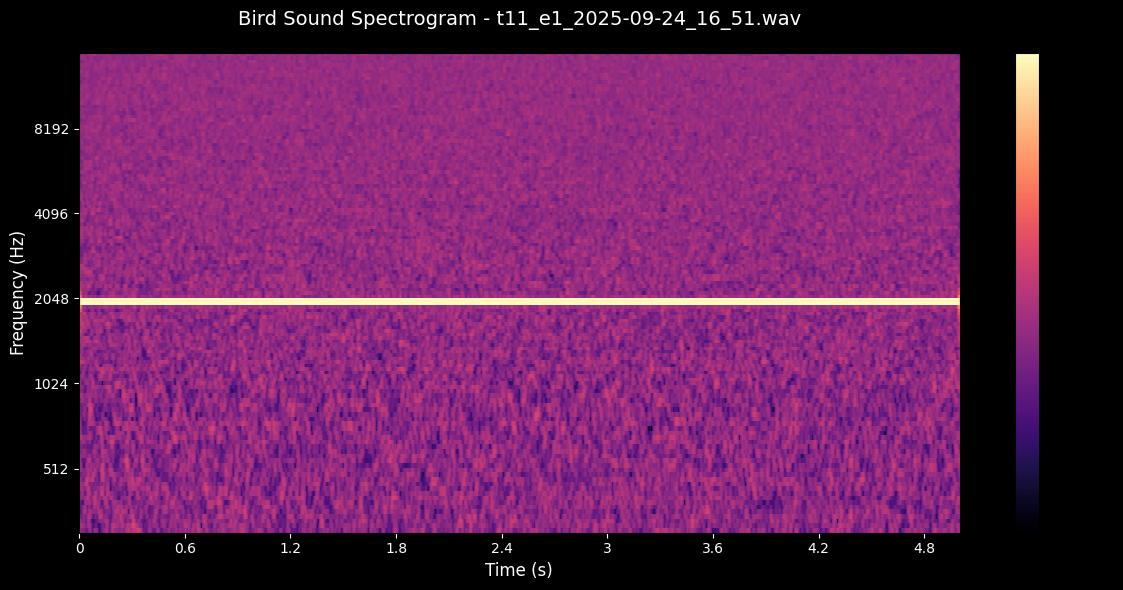

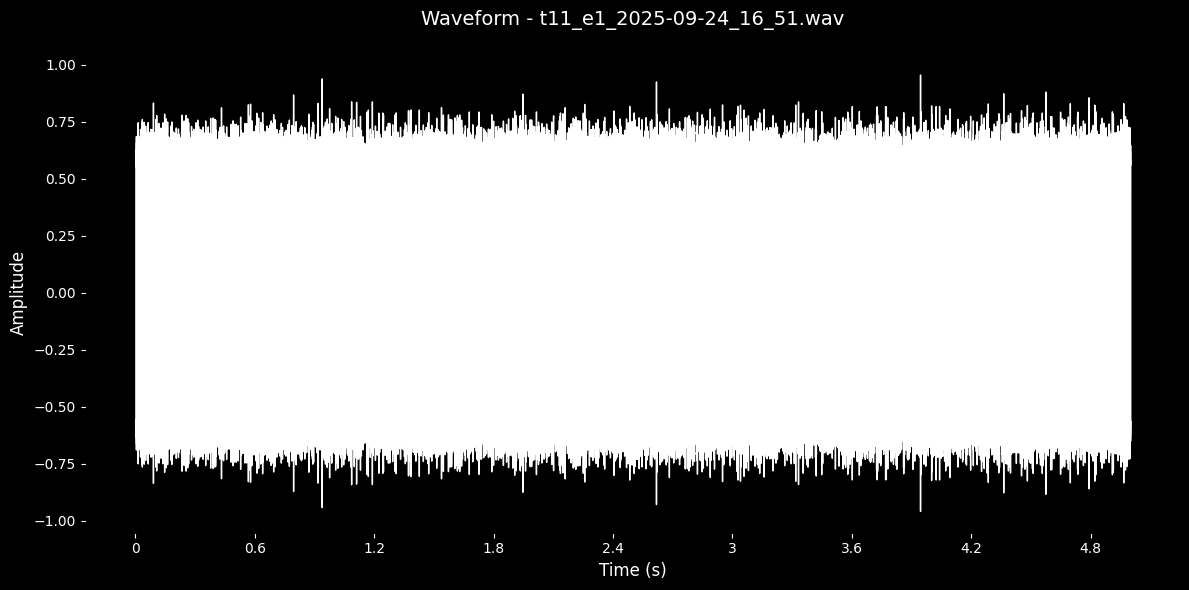

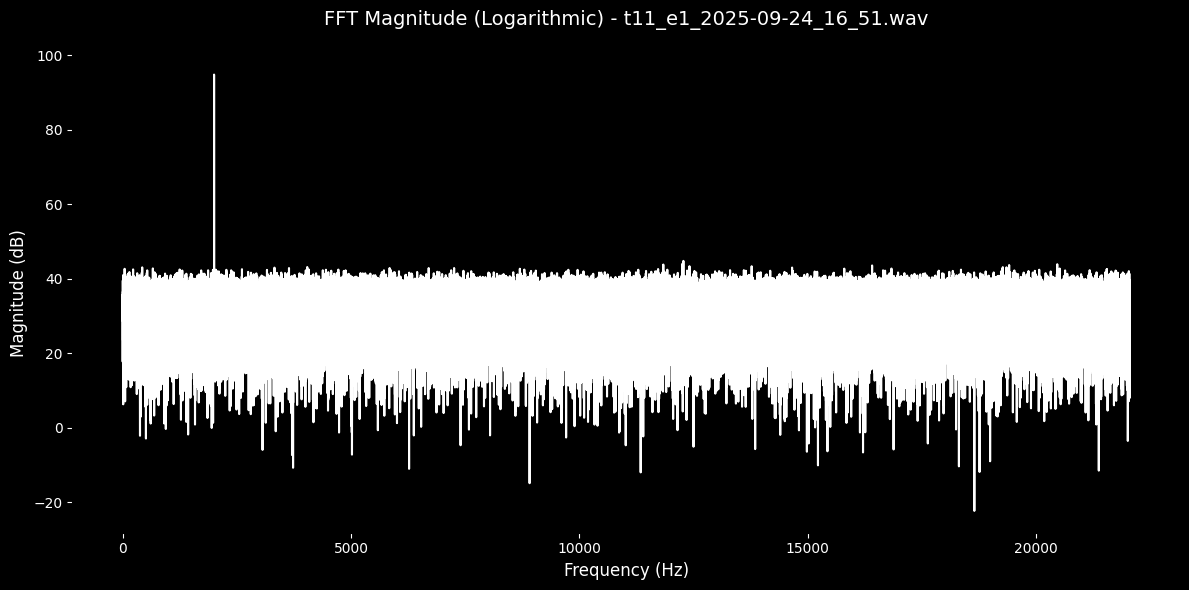

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import argparse
import os

def create_merlin_style_spectrogram(wav_file, output_file=None, show_plot=True):
    """
    Create a spectrogram that mimics the Merlin Bird ID app style.
    
    Parameters:
    wav_file (str): Path to the WAV file
    output_file (str): Path to save the spectrogram image (optional)
    show_plot (bool): Whether to display the plot
    """
    
    # Load audio file
    try:
        y, sr = librosa.load(wav_file, sr=None)  # Keep original sample rate
        print(f"Loaded audio: {len(y)} samples at {sr} Hz")
        print(f"Duration: {len(y)/sr:.2f} seconds")
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return
    
    # Merlin-style parameters
    n_fft = 2048        # Window size for FFT
    hop_length = 256    # Hop length (overlap)
    n_mels = 128        # Number of mel bands (frequency resolution)
    fmin = 150          # Minimum frequency (Hz) - filters out low-frequency noise
    fmax = 15000        # Maximum frequency (Hz) - covers most bird vocalizations
    
    # Create mel spectrogram (similar to what Merlin uses)
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
        power=2.0  # Power spectrum
    )
    
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Create the plot with Merlin-like styling
    plt.figure(figsize=(12, 6))
    img = librosa.display.specshow(
        mel_spec_db,
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        fmin=fmin,
        fmax=fmax,
        cmap='magma'
    )
    plt.colorbar(img, format='%+2.0f dB', label='Power (dB)')
    plt.title(f'Bird Sound Spectrogram - {os.path.basename(wav_file)}', fontsize=14, color='white', pad=20)
    plt.xlabel('Time (s)', fontsize=12, color='white')
    plt.ylabel('Frequency (Hz)', fontsize=12, color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.gca().tick_params(colors='white')
    plt.gca().xaxis.label.set_color('white')
    plt.gca().yaxis.label.set_color('white')
    plt.clim(vmin=mel_spec_db.max() - 60, vmax=mel_spec_db.max())
    plt.tight_layout()
    
    # Save if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight', 
                   facecolor='black', edgecolor='none')
        print(f"Spectrogram saved to: {output_file}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(y, sr=sr, color='white')
    plt.title(f'Waveform - {os.path.basename(wav_file)}', fontsize=14, color='white', pad=20)
    plt.xlabel('Time (s)', fontsize=12, color='white')
    plt.ylabel('Amplitude', fontsize=12, color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.gca().tick_params(colors='white')
    plt.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.close()

    # Plot the FFT
    fft_data = np.fft.fft(y)
    fft_freq = np.fft.fftfreq(len(y), 1/sr)
    
    # Only keep the positive frequencies
    fft_data = fft_data[:len(fft_data)//2]
    fft_freq = fft_freq[:len(fft_freq)//2]
    
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq, 20 * np.log10(np.abs(fft_data) + 1e-10), color='white')  # Add small value to avoid log(0)
    plt.title(f'FFT Magnitude (Logarithmic) - {os.path.basename(wav_file)}', fontsize=14, color='white', pad=20)
    plt.xlabel('Frequency (Hz)', fontsize=12, color='white')
    plt.ylabel('Magnitude (dB)', fontsize=12, color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.gca().tick_params(colors='white')
    plt.tight_layout()
    if show_plot:
        plt.show()
    else:
        plt.close()


def create_alternative_spectrogram(wav_file, output_file=None, show_plot=True):
    """
    Alternative approach using scipy for more control over the spectrogram.
    This version gives even more Merlin-like results.
    """
    
    # Load audio
    try:
        y, sr = librosa.load(wav_file, sr=None)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return
    
    # Pre-emphasis filter (enhances higher frequencies)
    pre_emphasis = 0.97
    y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])
    
    # Compute spectrogram using scipy
    f, t, Sxx = signal.spectrogram(
        y, 
        fs=sr, 
        window='hann',
        nperseg=2048,      # Window length
        noverlap=1792,     # Overlap (87.5%)
        nfft=2048,
        scaling='density'
    )
    
    # Focus on bird frequency range
    freq_mask = (f >= 150) & (f <= 15000)
    f_bird = f[freq_mask]
    Sxx_bird = Sxx[freq_mask, :]
    
    # Convert to dB and apply dynamic range compression
    Sxx_db = 10 * np.log10(Sxx_bird + 1e-10)  # Add small value to avoid log(0)
    
    # Dynamic range compression (similar to what Merlin does)
    vmin = np.percentile(Sxx_db, 10)  # 10th percentile
    vmax = np.percentile(Sxx_db, 98)  # 98th percentile
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f_bird, Sxx_db, shading='gouraud', cmap='magma',
                   vmin=vmin, vmax=vmax)
    plt.colorbar(label='Power Spectral Density (dB/Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Bird Sound Spectrogram (Alternative) - {os.path.basename(wav_file)}')
    
    # Apply Merlin-like styling
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.gca().tick_params(colors='white')
    plt.gca().xaxis.label.set_color('white')
    plt.gca().yaxis.label.set_color('white')
    plt.title(plt.gca().get_title(), color='white')
    
    plt.tight_layout()
    
    if output_file:
        alt_output = output_file.replace('.png', '_alternative.png')
        plt.savefig(alt_output, dpi=300, bbox_inches='tight',
                   facecolor='black', edgecolor='none')
        print(f"Alternative spectrogram saved to: {alt_output}")
    
    if show_plot:
        plt.show()
    else:
        plt.close()

def main():
    parser = argparse.ArgumentParser(description='Generate Merlin-style bird spectrograms')
    parser.add_argument('wav_file', help='Path to the WAV file')
    parser.add_argument('-o', '--output', help='Output image file path')
    parser.add_argument('--no-show', action='store_true', help='Don\'t display the plot')
    parser.add_argument('--alternative', action='store_true', help='Use alternative spectrogram method')
    
    args = parser.parse_args()
    
    if not os.path.exists(args.wav_file):
        print(f"Error: File '{args.wav_file}' not found.")
        return
    
    show_plot = not args.no_show
    
    if args.alternative:
        create_alternative_spectrogram(args.wav_file, args.output, show_plot)
    else:
        create_merlin_style_spectrogram(args.wav_file, args.output, show_plot)

if __name__ == "__main__":
    # Check if running in Jupyter (sys.argv will contain 'ipykernel_launcher.py')
    if 'ipykernel_launcher.py' in os.sys.argv[0] or len(os.sys.argv) == 1:
        # Running in Jupyter notebook - use hardcoded path
        wav_file_path = "t11_e1_2025-09-24_16_51.wav"
        print(f"Processing: {wav_file_path}")
        
        if not os.path.exists(wav_file_path):
            print(f"ERROR: File '{wav_file_path}' not found!")
            print("Please edit the 'wav_file_path' variable at the top of this script.")
        else:
            # Generate the spectrogram with waveform and FFT
            create_merlin_style_spectrogram(wav_file_path, output_file="spectrogram.png", show_plot=True)
    else:
        # Running from command line - use argument parser
        main()


Loaded audio: 220500 samples at 44100 Hz


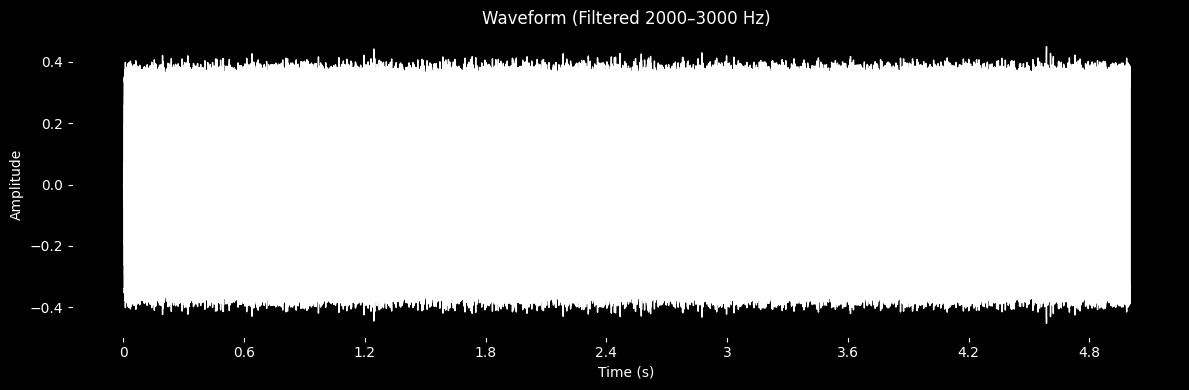

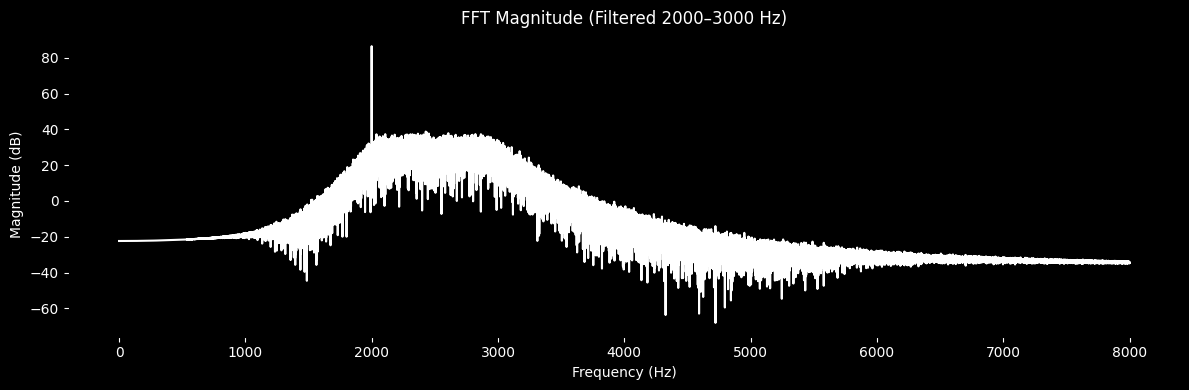

Spectrogram saved to: filtered_spectrogram.png


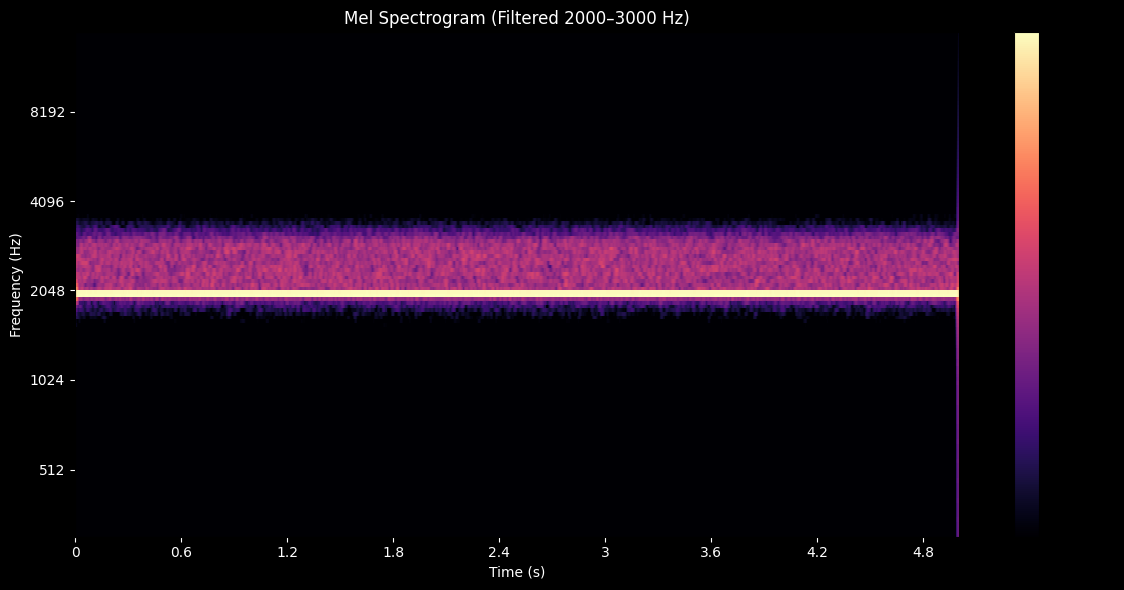

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, lfilter
import os

def bandpass_filter(data, sr, lowcut=2000.0, highcut=3000.0, order=5):
    """Butterworth bandpass filter."""
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def plot_all_filtered(wav_file, output_file=None, show_plot=True):
    """
    Process WAV file:
    - Apply bandpass filter (2000–3000 Hz)
    - Plot waveform, FFT, and Merlin-style mel spectrogram
    """
    try:
        y, sr = librosa.load(wav_file, sr=None)
        print(f"Loaded audio: {len(y)} samples at {sr} Hz")
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # Apply bandpass filter
    y_filtered = bandpass_filter(y, sr, lowcut=2000.0, highcut=3000.0)

    # === Waveform ===
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y_filtered, sr=sr, color='white')
    plt.title('Waveform (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Amplitude', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.tight_layout()
    if show_plot: plt.show()
    else: plt.close()

    # === FFT Plot ===
    window = np.hamming(len(y_filtered))
    y_windowed = y_filtered * window
    fft_data = np.fft.fft(y_windowed)
    fft_freq = np.fft.fftfreq(len(y_windowed), d=1/sr)

    # Keep only positive frequencies in 0–8000 Hz
    mask = (fft_freq > 0) & (fft_freq < 8000)
    fft_data = fft_data[mask]
    fft_freq = fft_freq[mask]

    plt.figure(figsize=(12, 4))
    plt.plot(fft_freq, 20 * np.log10(np.abs(fft_data) + 1e-10), color='white')
    plt.title('FFT Magnitude (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Frequency (Hz)', color='white')
    plt.ylabel('Magnitude (dB)', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.tight_layout()
    if show_plot: plt.show()
    else: plt.close()

    # === Mel Spectrogram ===
    n_fft = 2048
    hop_length = 256
    n_mels = 128
    fmin = 150
    fmax = 15000

    mel_spec = librosa.feature.melspectrogram(
        y=y_filtered, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(12, 6))
    img = librosa.display.specshow(
        mel_spec_db, sr=sr, hop_length=hop_length,
        x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax, cmap='magma'
    )
    plt.colorbar(img, format='%+2.0f dB', label='Power (dB)')
    plt.title('Mel Spectrogram (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Frequency (Hz)', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.clim(vmin=mel_spec_db.max() - 60, vmax=mel_spec_db.max())
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight',
                    facecolor='black', edgecolor='none')
        print(f"Spectrogram saved to: {output_file}")
    if show_plot: plt.show()
    else: plt.close()

# ===================== MAIN EXECUTION =====================

if __name__ == "__main__":
    # Edit your file path here
    wav_file_path = "t11_e1_2025-09-24_16_51.wav"

    if not os.path.exists(wav_file_path):
        print(f"File not found: {wav_file_path}")
    else:
        plot_all_filtered(wav_file_path, output_file="filtered_spectrogram.png", show_plot=True)


Loaded audio: 220500 samples at 44100 Hz


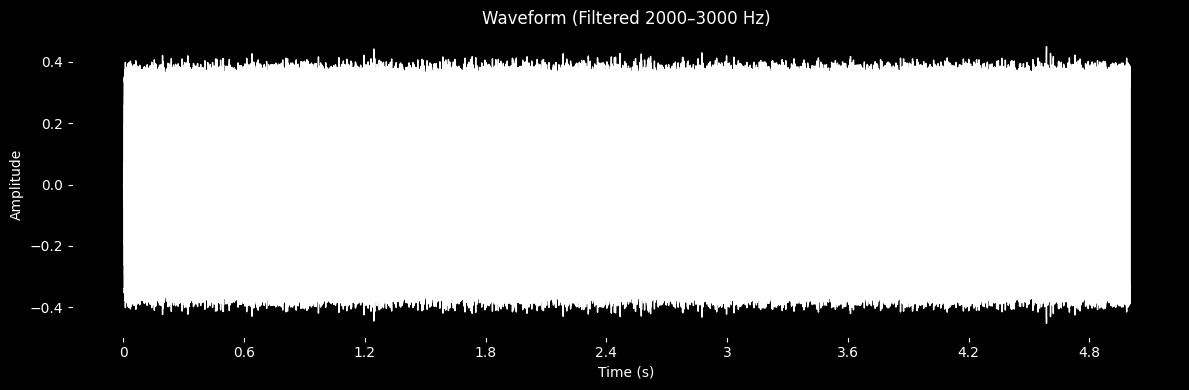

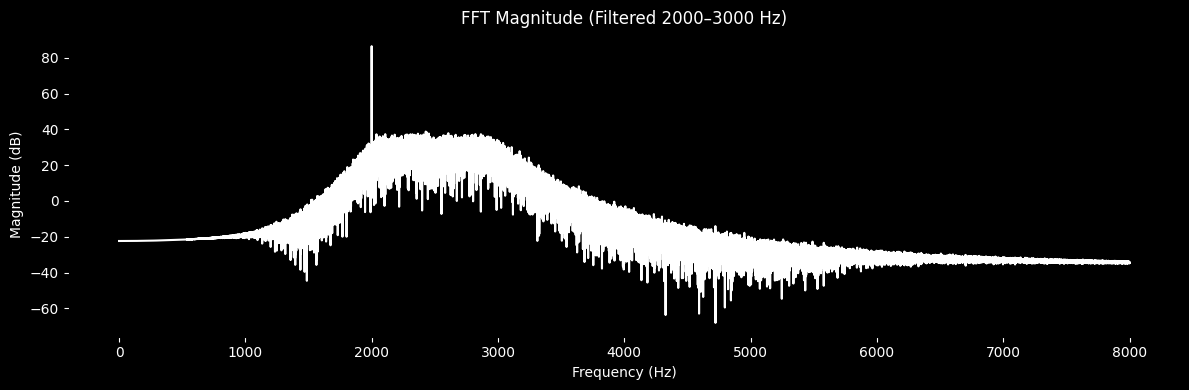

Spectrogram saved to: filtered_spectrogram.png


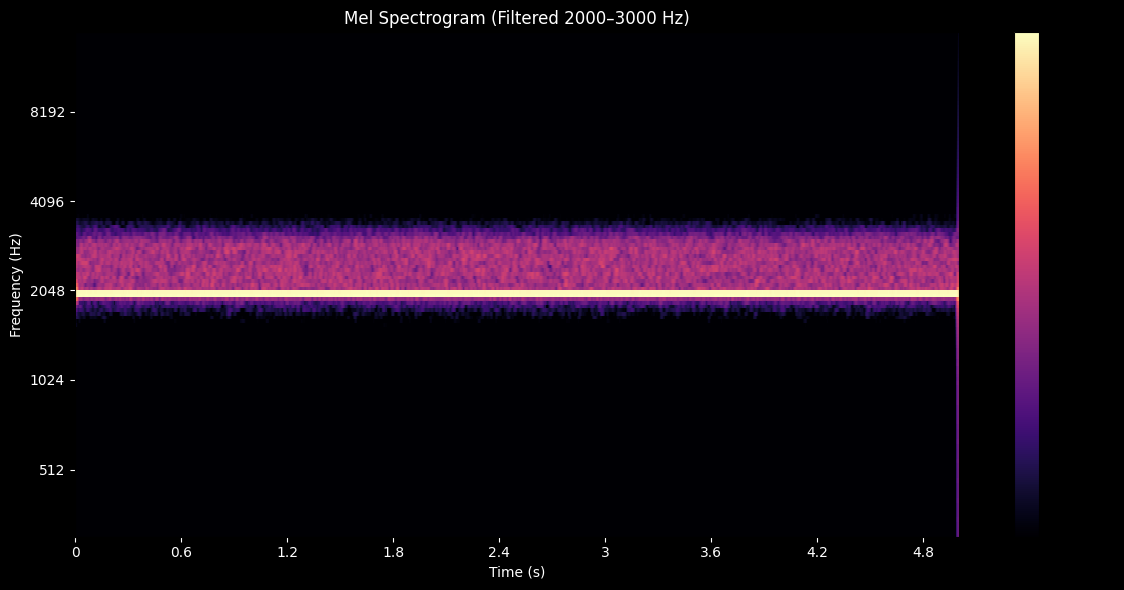

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, lfilter
import os

def bandpass_filter(data, sr, lowcut=2000.0, highcut=3000.0, order=5):
    """Butterworth bandpass filter."""
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def plot_all_filtered(wav_file, output_file=None, show_plot=True):
    """
    Process WAV file:
    - Apply bandpass filter (2000–3000 Hz)
    - Plot waveform, FFT, and Merlin-style mel spectrogram
    """
    try:
        y, sr = librosa.load(wav_file, sr=None)
        print(f"Loaded audio: {len(y)} samples at {sr} Hz")
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # Apply bandpass filter
    y_filtered = bandpass_filter(y, sr, lowcut=2000.0, highcut=3000.0)

    # === Waveform ===
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y_filtered, sr=sr, color='white')
    plt.title('Waveform (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Amplitude', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.tight_layout()
    if show_plot: plt.show()
    else: plt.close()

    # === FFT Plot ===
    window = np.hamming(len(y_filtered))
    y_windowed = y_filtered * window
    fft_data = np.fft.fft(y_windowed)
    fft_freq = np.fft.fftfreq(len(y_windowed), d=1/sr)

    # Keep only positive frequencies in 0–8000 Hz
    mask = (fft_freq > 0) & (fft_freq < 8000)
    fft_data = fft_data[mask]
    fft_freq = fft_freq[mask]

    plt.figure(figsize=(12, 4))
    plt.plot(fft_freq, 20 * np.log10(np.abs(fft_data) + 1e-10), color='white')
    plt.title('FFT Magnitude (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Frequency (Hz)', color='white')
    plt.ylabel('Magnitude (dB)', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.tight_layout()
    if show_plot: plt.show()
    else: plt.close()

    # === Mel Spectrogram ===
    n_fft = 2048
    hop_length = 256
    n_mels = 128
    fmin = 150
    fmax = 15000

    mel_spec = librosa.feature.melspectrogram(
        y=y_filtered, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(12, 6))
    img = librosa.display.specshow(
        mel_spec_db, sr=sr, hop_length=hop_length,
        x_axis='time', y_axis='mel', fmin=fmin, fmax=fmax, cmap='magma'
    )
    plt.colorbar(img, format='%+2.0f dB', label='Power (dB)')
    plt.title('Mel Spectrogram (Filtered 2000–3000 Hz)', color='white')
    plt.xlabel('Time (s)', color='white')
    plt.ylabel('Frequency (Hz)', color='white')
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    plt.tick_params(colors='white')
    plt.clim(vmin=mel_spec_db.max() - 60, vmax=mel_spec_db.max())
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight',
                    facecolor='black', edgecolor='none')
        print(f"Spectrogram saved to: {output_file}")
    if show_plot: plt.show()
    else: plt.close()

# ===================== MAIN EXECUTION =====================

if __name__ == "__main__":
    # Edit your file path here
    wav_file_path = "t11_e1_2025-09-24_16_51.wav"

    if not os.path.exists(wav_file_path):
        print(f"File not found: {wav_file_path}")
    else:
        plot_all_filtered(wav_file_path, output_file="filtered_spectrogram.png", show_plot=True)
